In [21]:
import sys
import matplotlib.pyplot as plt
import torch
import numpy as np
import pickle as pkl
sys.path.append('../../../')


from riemannian_geometry.computations import geomancer
from models.data.sklearn_datasets import MoonDataset, BlobsDataset
from models.supervised.mlp.model import MLP
from riemannian_geometry.computations.pullback_metric import pullback_all_metrics

models_path = "../../../models/supervised/mlp/saved_models"


In [22]:
np.random.seed(2)
torch.manual_seed(2)

In [375]:
size = "vanilla"
mode = "blobs"
epoch = 199
model = MLP(2,7,4,4)
with open(f'{models_path}/{size}/mlp_{mode}/dataset.pkl', 'rb') as f:
	dataset = pkl.load(f)

full_path = f'{models_path}/{size}/mlp_{mode}/model_{epoch}.pth'
model.load_state_dict(torch.load(full_path))

model.eval()

	
	

MLP(
  (layers): ModuleList(
    (0): Layer(
      (act_func): Tanh()
      (linear_map): Linear(in_features=2, out_features=4, bias=True)
    )
    (1-5): 5 x Layer(
      (act_func): Tanh()
      (linear_map): Linear(in_features=4, out_features=4, bias=True)
    )
    (6): Layer(
      (act_func): Sigmoid()
      (linear_map): Linear(in_features=4, out_features=4, bias=True)
    )
  )
)

In [376]:
N=50
wrt = "output_wise"
sigma = 0.05

X = torch.from_numpy(dataset.X).float()
labels = dataset.y


model.forward(X, save_activations=True)

activations = model.get_activations()
activations_np = [a.detach().numpy() for a in activations]
g, dg, ddg, surface = pullback_all_metrics(model, activations, N, wrt=wrt, method="manifold", sigma=sigma, normalised=True)
	

In [409]:

"""
Code for the Modified Geometric Manifold Component Estimator (GEOMANCER). 
Largerly based off the DeepMind paper ``Disentangling by Subspace Diffusion``
"""

import itertools

from absl import logging

import numpy as np
import scipy
import scipy.sparse
import scipy.sparse.linalg
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from tqdm import tqdm
from models.data.sklearn_datasets import MoonDataset
import matplotlib.pyplot as plt
from matplotlib import gridspec

def sym_op(x, zero_trace=False):
	"""Given X, makes L(A) = X @ A @ X' for symmetric matrices A.

	If A is not symmetric, L(A) will return X @ (A_L + A_L') @ X' where A_L is
	the lower triangular of A (with the diagonal divided by 2).

	Args:
		x: The matrix from which to construct the operator
		zero_trace (optional): If true, restrict the operator to only act on
			matrices with zero trace, effectively reducing the dimensionality by one.
	Returns:
		A matrix Y such that vec(L(A)) = Y @ vec(A).
	"""
	n = x.shape[0]
	# Remember to subtract off the diagonal once
	xx = (np.einsum('ik,jl->ijkl', x, x) +
				np.einsum('il,jk->ijkl', x, x) -
				np.einsum('ik,jl,kl->ijkl', x, x, np.eye(n)))
	xx = xx[np.tril_indices(n)]
	xx = xx.transpose(1, 2, 0)
	xx = xx[np.tril_indices(n)]
	xx = xx.T
	if zero_trace:
		diag_idx = np.cumsum([0]+list(range(2, n)))
		proj_op = np.eye(n*(n+1)//2)[:, :-1]
		proj_op[-1, diag_idx] = -1
		# multiply by operator that completes last element of diagonal
		# for a zero-trace matrix
		xx = xx @  proj_op
		xx = xx[:-1]
	return xx


def vec_to_sym(x, n, zero_trace=False):
	y = np.zeros((n, n))
	if zero_trace:
		x = np.append(x, 0.0)
	y[np.tril_indices(n)] = x
	y += y.T
	y[np.diag_indices(n)] /= 2.0
	if zero_trace:
		y[-1, -1] = -np.trace(y)
	return y


def ffdiag(data, lr=1.0, tol=1e-10, verbose=False, eig_init=False):
	"""Orthogonal FFDiag algorithm of Ziehe et al 2004."""
	n = data.shape[1]
	k = data.shape[0]
	c = data.copy()
	if eig_init:
		_, v = np.linalg.eig(data[0])
		v = v.T
		for i in range(k):
			c[i] = v @ c[i] @ v.T
	else:
		v = np.eye(n)

	err_ = np.inf
	for t in range(10000):
		w = np.zeros((n, n))
		for i in range(n):
			for j in range(i+1, n):
				diag = c[:, i, i] - c[:, j, j]
				w[i, j] = np.sum(c[:, i, j] * diag) / np.sum(diag ** 2)
		w -= w.T
		norm = np.linalg.svd(w, compute_uv=False).max()
		if norm > lr:
			w *= lr / norm
		ew = scipy.linalg.expm(w)
		v = ew @ v
		for i in range(k):
			c[i] = ew @ c[i] @ ew.T
		cdiag = c.copy()
		for i in range(n):
			for j in range(k):
				cdiag[j, i, i] = 0
		err = np.linalg.norm(cdiag)
		if verbose:
			logging.info('Iter %d: %f', t, err)
		if err_ - err < tol and err_ - err >= 0:
			return v
		err_ = err
	return v


def avg_angle_between_subspaces(xs, ys):
	"""Compute the error between two sets of subspaces."""
	if len(xs) != len(ys):
		return np.pi / 2  # largest possible angle
	angles = []
	for ys_perm in itertools.permutations(ys):
		angles.append([])
		for i in range(len(xs)):
			if xs[i].shape[1] == ys_perm[i].shape[1]:
				sigma = np.linalg.svd(xs[i].T @ ys_perm[i], compute_uv=False)
				angles[-1].append(np.arccos(np.min(sigma)))
			else:
				angles[-1].append(np.pi / 2)
	angles = np.array(angles)
	return np.min(np.mean(angles, axis=1))


def make_nearest_neighbors_graph(data, k):
	n = data.shape[0]
	nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(data)
	distances, indices = nbrs.kneighbors(data)

	row_indices = np.repeat(indices[:, 0], k)
	col_indices = indices[:, 1:].reshape(-1)
	data = np.ones(row_indices.shape[0])

	# Create a sparse matrix in COO format
	nbr_graph = scipy.sparse.coo_matrix((data, (row_indices, col_indices)), shape=(n, n))
	# Make the graph symmetric by adding its transpose
	nbr_graph = nbr_graph + nbr_graph.T
	nbr_graph.data = np.where(nbr_graph.data > 0, 1, 0)

	# Convert to CSR format for efficient arithmetic and storage
	nbr_graph = nbr_graph.tocsr()
	

	return nbr_graph

def custom_metric(x, y, G):
	return np.dot(np.dot(x.T, G), y)

def dist_metric_nn_graph(data, G, k, use_in_degree=False):
	n = data.shape[0]
	nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(data)
	distances, indices = nbrs.kneighbors(data)
	
	row_indices = np.repeat(indices[:, 0], k)
	col_indices = indices[:, 1:].reshape(-1)
	metric = np.zeros(row_indices.shape[0])
	for c in col_indices:
		for r in row_indices:
			if use_in_degree:
				metric[c] = custom_metric(data[c], data[r], G[c])
			else:
				metric[c] = custom_metric(data[c], data[r], G[r])

	# Create a sparse matrix in COO format
	nbr_graph = scipy.sparse.coo_matrix((metric, (row_indices, col_indices)), shape=(n, n))
	# Convert to CSR format for efficient arithmetic and storage
	nbr_graph = nbr_graph.tocsr()
	return nbr_graph

def metric_nn_graph(data, G, k, use_in_degree=False):
	n = data.shape[0]
	distance_matrix = np.zeros((n, n))
	dets = np.abs(np.linalg.det(G))
	for i in range(n):
		for j in range(i+1, n):
			if use_in_degree:
				d = dets[i]
			else:
				d = dets[j]
			distance_matrix[i, j] = np.linalg.norm(data[i] - data[j])**2 + d
			distance_matrix[j, i] = distance_matrix[i, j]
	plt.hist(distance_matrix.flatten(), bins=100)
	plt.show()
	nbrs = NearestNeighbors(n_neighbors=k+1, metric='precomputed').fit(distance_matrix)
	_, indices = nbrs.kneighbors(distance_matrix)
	
	row_indices = np.repeat(indices[:, 0], k)
	col_indices = indices[:, 1:].reshape(-1)
	data = np.ones(row_indices.shape[0])
	
	# Create a sparse matrix in COO format
	nbr_graph = scipy.sparse.coo_matrix((data, (row_indices, col_indices)), shape=(n, n))
	nbr_graph = nbr_graph + nbr_graph.T
	nbr_graph.data = np.where(nbr_graph.data > 0, 1, 0)
	# Convert to CSR format for efficient arithmetic and storage
	nbr_graph = nbr_graph.tocsr()
	return nbr_graph


def make_tangents_from_metric_eigenvectors(metric_g):
	eig_vals, tangents = np.linalg.eig(metric_g)
	tangents = tangents / np.sqrt(np.abs(eig_vals[:, :, np.newaxis])+1e-8)
	return tangents


def make_tangents(data, neighbor_graph, k):
	"""Construct all tangent vectors for the dataset."""
	tangents = np.zeros((data.shape[0], k, data.shape[1]), dtype=np.float32)
	for i in tqdm(range(data.shape[0])):
		# Adapted for CSR format
		diff = data[neighbor_graph[i].indices] - data[i]
		_, _, u = np.linalg.svd(diff, full_matrices=False)
		tangents[i] = u[:k]
	logging.info('Computed all tangents')
	return tangents

def make_connection(tangents, neighbor_graph):
	"""Make connection matrices for all edges of the neighbor graph."""
	connection = {}
	for i in tqdm(range(tangents.shape[0])):
		# Adapted for CSR format
		for j in neighbor_graph[i].indices:
			uy, _, ux = np.linalg.svd(tangents[j] @ tangents[i].T,
									  full_matrices=False)
			conn = uy @ ux
			connection[(i, j)] = conn

	logging.info('Constructed all connection matrices')
	return connection

def make_laplacian(connection, neighbor_graph, sym=False, zero_trace=True):
	"""Make symmetric zero-trace second-order graph connection Laplacian."""
	n = neighbor_graph.shape[0]
	k = list(connection.values())[0].shape[0]
	bsz = (k*(k+1)//2 - 1 if zero_trace else k*(k+1)//2) if sym else k**2
	data = np.zeros((neighbor_graph.nnz + n, bsz, bsz), dtype=np.float32)
	indptr = []
	indices = np.zeros(neighbor_graph.nnz + n)
	index = 0
	for i in tqdm(range(n)):
		indptr.append(index)
		data[index] = len(neighbor_graph[i].indices) * np.eye(bsz)
		indices[index] = i
		index += 1
		for j in neighbor_graph[i].indices:
			if sym:
				kron = sym_op(connection[(j, i)], zero_trace=zero_trace)
			else:
				kron = np.kron(connection[(j, i)], connection[(j, i)])
			data[index] = -kron
			indices[index] = j
			index += 1
	indptr.append(index)
	indptr = np.array(indptr)

	laplacian = scipy.sparse.bsr_matrix((data, indices, indptr),
																			shape=(n*bsz, n*bsz))
	logging.info('Built 2nd-order graph connection Laplacian.')
	return laplacian


def cluster_subspaces(omega):
	"""Cluster different dimensions from the eigenvectors of the Laplacian."""
	w = ffdiag(omega)  # simultaneous diagonalization
	psi = np.zeros(omega.shape[:2])
	for i in range(omega.shape[0]):
		psi[i] = np.diag(w @ omega[i] @ w.T)  # compute diagonals
	# Compute cosine similarity of diagonal vectors
	psi_outer = psi.T @ psi
	psi_diag = np.diag(psi_outer)
	cos_similarity = psi_outer / np.sqrt(np.outer(psi_diag, psi_diag))
	adj = cos_similarity > 0.5  # adjacency matrix for graph of clusters
	# Use graph Laplacian to find cliques
	# (though a greedy algorithm could work too)
	lapl = np.diag(np.sum(adj, axis=0)) - adj  # graph Laplacian
	d, v = np.linalg.eig(lapl)
	# connected components of graph
	cliques = np.abs(v[:, np.abs(d) < 1e-6]) > 1e-6
	tangents = [w[cliques[:, i]] for i in range(sum(np.abs(d) < 1e-6))]

	return tangents
def cluter_manifolds(eigvecs, sig_indx):
	sig_eigenvecs = eigvecs[:, :, sig_indx]
	kmeans = KMeans(n_clusters=sig_indx, random_state=0).fit(sig_eigenvecs)
	return kmeans

def fit(data, k, metric_g, gamma=None, nnbrs=None, neig=10, in_degree=False):
	"""The Geometric Manifold Component Estimator.

	Args:
		data: the dataset, a set of points sample from a product manifold.
		k: the dimensionality of the manifold.
		gamma (optional): the threshold in the spectrum at which to cut off the
			number of submanifolds.
		nnbrs (optional): number of neighbors to use for each point.

	Returns:
		A list of lists of subspace bases, one list for each element of the dataset,
		and the spectrum of the 2nd-order graph Laplacian.
	"""
	if not nnbrs:
		nnbrs = 2*k
	#neighbor_graph = make_nearest_neighbors_graph(data, nnbrs)
	neighbor_graph = metric_nn_graph(data, metric_g, nnbrs, use_in_degree=in_degree)
	#neighbor_graph = dist_metric_nn_graph(data, metric_g, nnbrs, use_in_degree=in_degree)

	tangents = make_tangents_from_metric_eigenvectors(metric_g)
	#tangents = make_tangents(data, neighbor_graph, k)
	connection = make_connection(tangents, neighbor_graph)
	laplacian = make_laplacian(connection, neighbor_graph)
	eigvals, eigvecs = scipy.sparse.linalg.eigsh(laplacian, k=neig, which='SM')
	logging.info('Computed bottom eigenvectors of 2nd-order Laplacian')
	bsz = k*(k+1)//2 - 1  # Block size for the projected 2nd-order Laplacian
	if gamma:
		nm = np.argwhere(eigvals < gamma)[-1, 0] + 1
	else:  # If no threshold is provided, just use the largest gap in the spectrum
		nm = np.argmax(eigvals[1:] - eigvals[:-1]) + 1
	eigvecs = eigvecs.reshape(data.shape[0], bsz, neig)
	omega = np.zeros((nm, k, k), dtype=np.float32)
	components = []
	for i in tqdm(range(data.shape[0])):
		for j in range(nm):
			omega[j] = vec_to_sym(eigvecs[i, :, j], k, zero_trace=True)
		components.append([tangents[i].T @ x.T for x in cluster_subspaces(omega)])
	membership = cluter_manifolds(eigvecs, nm)
	logging.info('GEOMANCER completed')
	return components, membership, neighbor_graph, eigvals, eigvecs


def eval_aligned(tangents, true_tangents):
	"""Evaluation for aligned data."""
	errors = np.zeros(len(tangents))
	for i in tqdm(range(len(tangents))):
		errors[i] = avg_angle_between_subspaces([gt[i] for gt in true_tangents],
																						tangents[i])
	logging.info('Computed angles between ground truth and GEOMANCER results')
	return errors


def eval_unaligned(data, tangents, true_data, true_tangents, k=10):
	"""Evaluation for unaligned data."""
	logging.info('Evaluating unaligned data')
	errors = np.zeros(data.shape[0])
	nbrs = make_nearest_neighbors_graph(true_data, k=k)

	for i in tqdm(range(data.shape[0])):
		tangent = np.concatenate(tangents[i], axis=1)
		true_tangent = np.concatenate([t[i] for t in true_tangents], axis=1)
		dx_true = (true_data[nbrs.rows[i]] - true_data[i]) @ true_tangent
		dx_result = (data[nbrs.rows[i]] - data[i]) @ tangent

		# compute canonical correlations between the two dxs
		xx = dx_true.T @ dx_true
		yy = dx_result.T @ dx_result
		xy = dx_true.T @ dx_result
		xx_ = np.linalg.inv(xx)
		yy_ = np.linalg.inv(yy)
		foo = scipy.linalg.sqrtm(xx_) @ xy @ scipy.linalg.sqrtm(yy_)
		u, _, v = np.linalg.svd(foo)

		# project subspaces for results and ground truth into aligned space
		proj = [v @ tangent.T @ s for s in tangents[i]]
		true_proj = [u.T @ true_tangent.T @ s[i] for s in true_tangents]
		errors[i] = avg_angle_between_subspaces(proj, true_proj)
	return errors



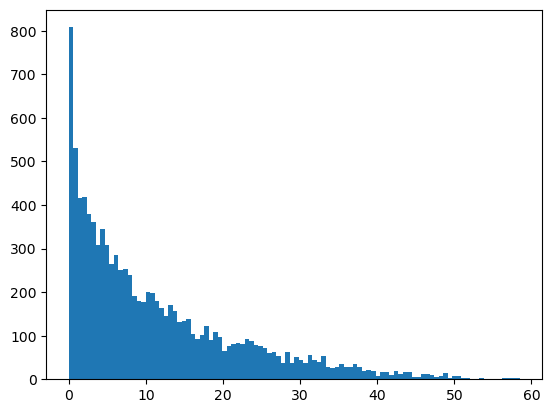

100%|██████████| 100/100 [00:00<00:00, 2067.48it/s]


ValueError: cannot reshape array of size 4000 into shape (100,2,10)

In [410]:
indx = 0
rand_ints = np.random.randint(0, len(surface[indx]), 100)
def rescale_g(g, points):
    n_points, _, _ = g.shape
    # Plots pull_forward or pull_back metric on the surface of the neural networks learnt functions
    max_points = np.max(points, axis=0)
    min_points = np.min(points, axis=0)

    g *= (max_points - min_points)/np.sqrt(n_points)

    return g
g_rescale = rescale_g(g[indx], surface[indx])
#rand_ints = np.arange(0, len(surface[indx]), 1)
surface_ = surface[indx][rand_ints]
g_rescale = g_rescale[rand_ints]
activation_ = activations_np[indx]
components, manifold, graph, eigvals, eigvecs = fit(surface_, 2, g_rescale, gamma=None, nnbrs=None)

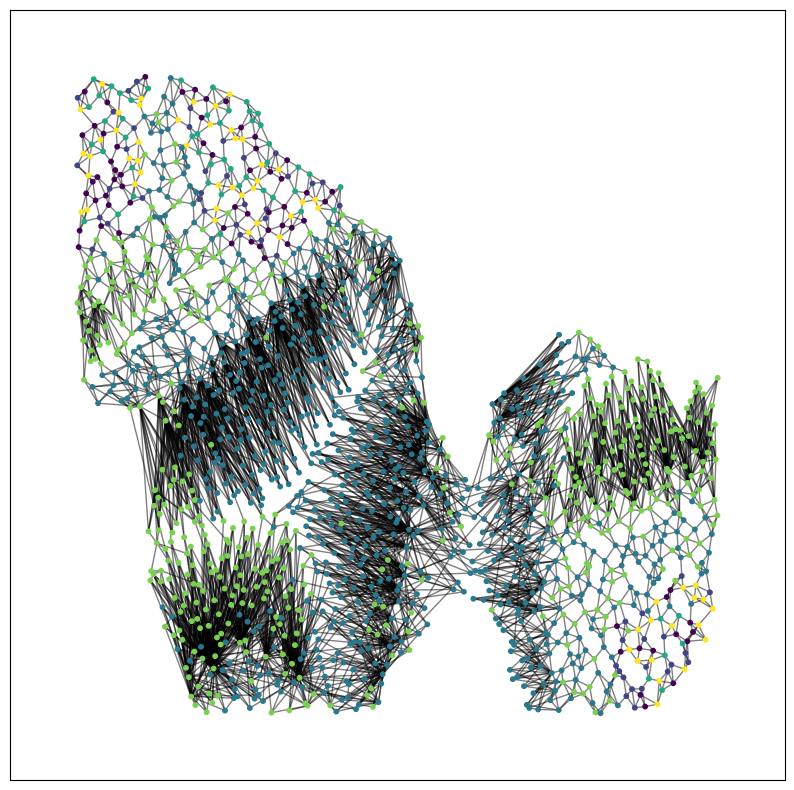

In [379]:
import networkx as nx
G = nx.from_scipy_sparse_array(graph)
pos = {i: surface_[i] for i in range(len(surface_))}

plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G, pos, node_size=10, node_color=manifold.labels_)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()


Text(0.5, 1.0, 'GeoManCEr Eigenvalue Spectrum')

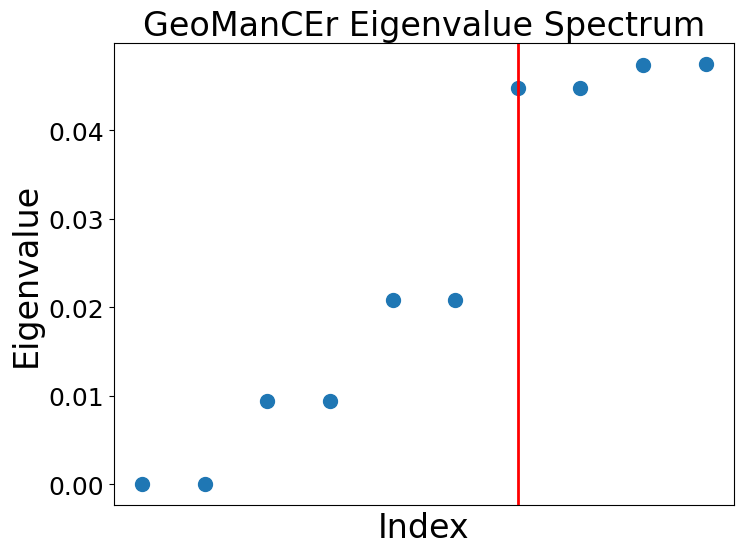

In [380]:
plt.figure(figsize=(8, 6))
plt.scatter(np.arange(len(eigvals)), eigvals, s=100)
largest_gap = np.argmax(eigvals[1:]-eigvals[:-1]) + 1
plt.axvline(largest_gap, linewidth=2, c='r')
plt.xticks([])
plt.yticks(fontsize=18)
plt.xlabel('Index', fontsize=24)
plt.ylabel('Eigenvalue', fontsize=24)
plt.title('GeoManCEr Eigenvalue Spectrum', fontsize=24)


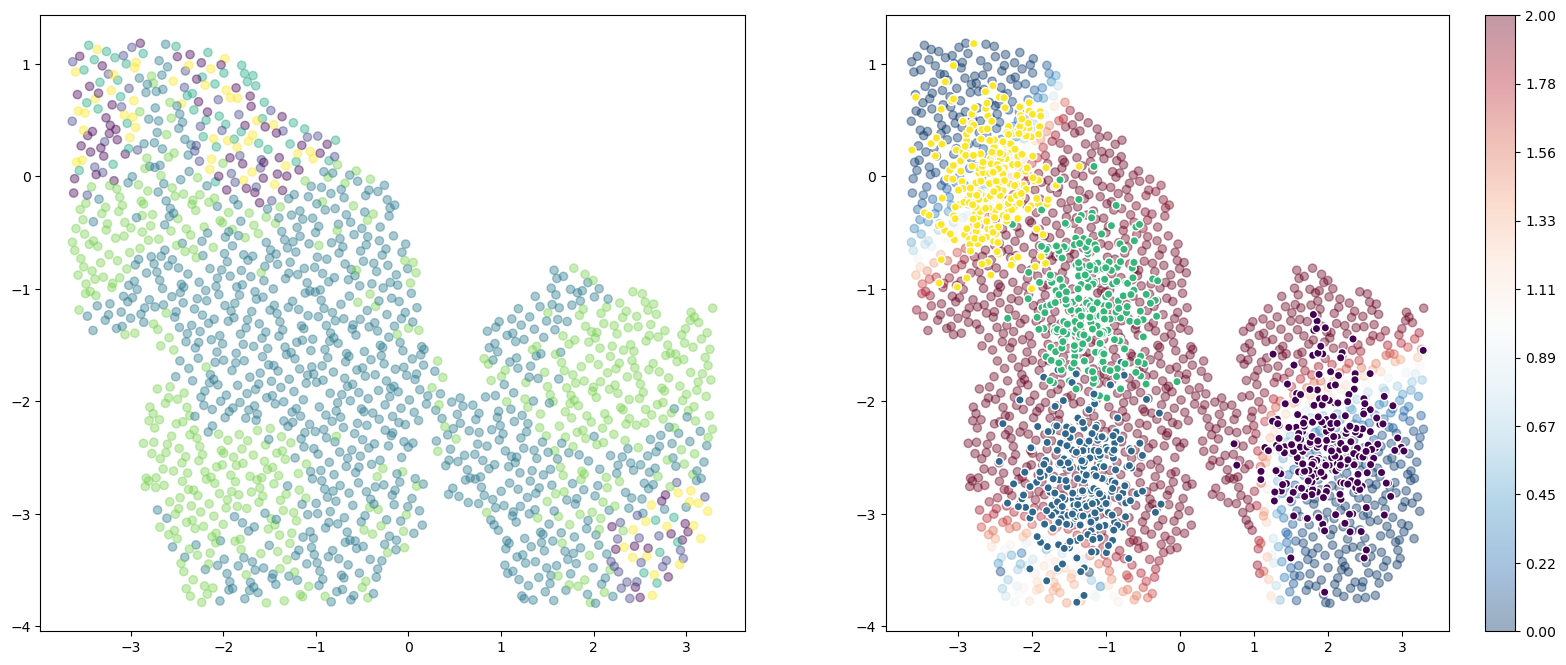

In [382]:
import networkx as nx

#rand_ints = np.random.randint(0, len(surface[indx]), 100)
#rand_ints = np.arange(0, len(surface[indx]), 1)
#surface_ = surface[indx][rand_ints]
#g_ = g[indx][rand_ints]
#activation_ = activations_np[indx]
#norm = np.linalg.norm(g[indx], axis=(1, 2), ord='fro')
#colour = plt.scatter(surface[indx][:, 0], surface[indx][:, 1], c=norm, marker='o', cmap='RdBu_r')
#plt.scatter(activation_[:, 0], activation_[:, 1], c=dataset.y)
#plt.colorbar(colour)
#plt.show()

fig, ax = plt.subplots(1, 2,figsize=(20, 8))
Z = np.linalg.norm(g_, axis=(1, 2), ord='fro')
Z_c = (Z - Z.min()) / (Z.max() - Z.min())
ax[0].scatter(surface_[:, 0], surface_[:, 1], c=manifold.labels_, alpha=0.4)

color = ax[1].scatter(surface_[:, 0], surface_[:, 1], c=Z_c, cmap='RdBu_r', alpha=0.4)
color_tickers = np.linspace(Z.min(), Z.max(), 10)
cbar_1 = fig.colorbar(color, ax=ax[1])
cbar_1.set_ticks(np.linspace(0, 1, len(color_tickers)))
cbar_1.set_ticklabels([f"{x:.2f}" for x in color_tickers])

color_tickers = np.linspace(Z.min(), Z.max(), 10)
ax[1].scatter(activation_[:, 0], activation_[:, 1], c=dataset.y, edgecolors='white')
plt.show()

[-1.41363978 -1.03434645 -0.65505311 -0.27575978  0.10353356  0.4828269
  0.86212023  1.24141357  1.6207069   2.00000024]
[-1.41363978 -1.03434645 -0.65505311 -0.27575978  0.10353356  0.4828269
  0.86212023  1.24141357  1.6207069   2.00000024]


/var/folders/b_/x8lg97sd7512c9qf07myy77m0000gn/T/ipykernel_63114/1631782319.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


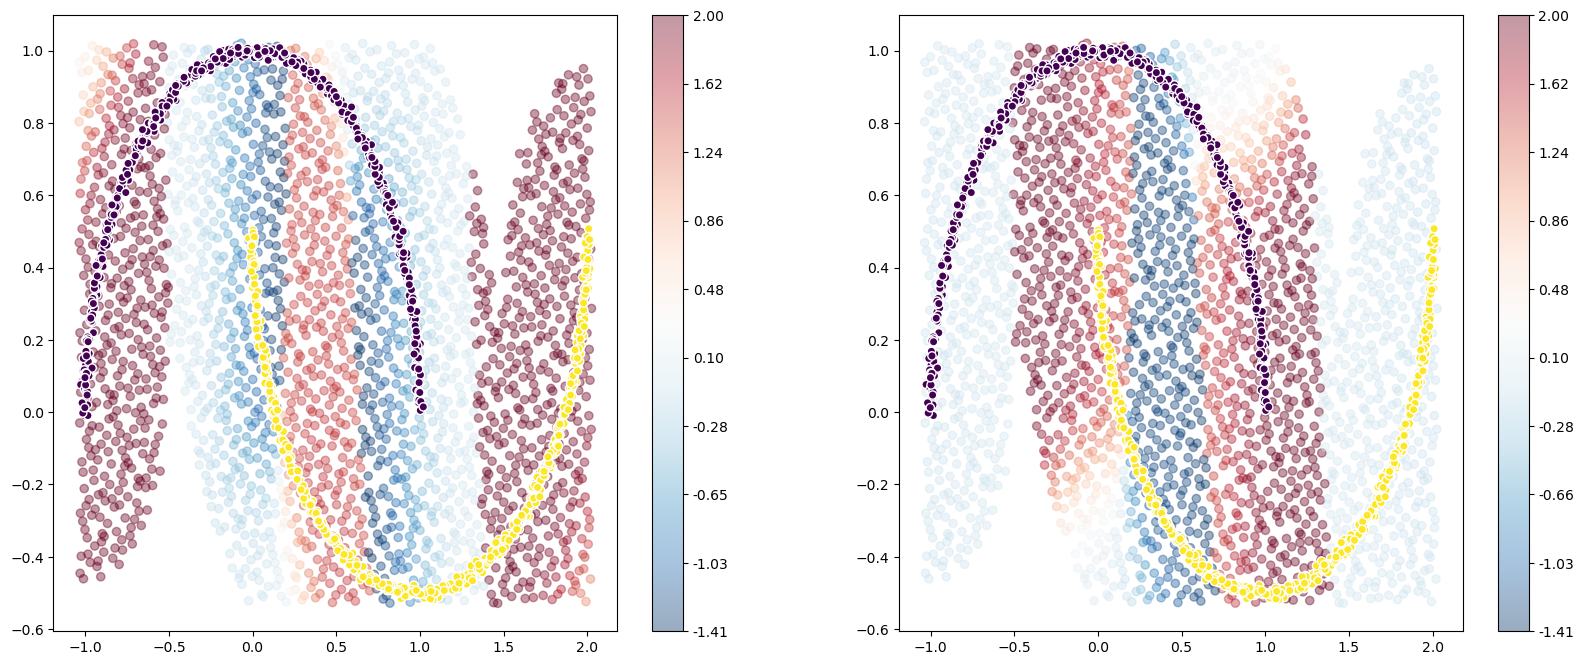

In [329]:
fig, ax = plt.subplots(1, 2,figsize=(20, 8))

eigenvalues, eigenvectors  = np.linalg.eig(g_)
#First subplot
Z_c = (eigenvalues[:, 0] - eigenvalues[:, 0].min()) / (eigenvalues[:, 0].max() - eigenvalues[:, 0].min() + 1e-8)
color = ax[0].scatter(surface_[:, 0], surface_[:, 1], c=Z_c, cmap='RdBu_r', alpha=0.4, vmin=0, vmax=1)
print(color_tickers)

color_tickers = np.linspace(eigenvalues[:, 0].min(), eigenvalues[:, 0].max(), 10)
cbar = fig.colorbar(color, ax=ax[0])
cbar.set_ticks(np.linspace(0, 1, len(color_tickers)))
cbar.set_ticklabels([f"{x:.2f}" for x in color_tickers])

# Second subplot
Z_c = (eigenvalues[:, 1] - eigenvalues[:, 1].min()) / (eigenvalues[:, 1].max() - eigenvalues[:, 1].min() + 1e-8)
color_1 = ax[1].scatter(surface_[:, 0], surface_[:, 1], c=Z_c, cmap='RdBu_r', alpha=0.4, vmin=0, vmax=1)
color_tickers = np.linspace(eigenvalues[:, 1].min(), eigenvalues[:, 1].max(), 10)
print(color_tickers)
cbar_1 = fig.colorbar(color_1, ax=ax[1])
cbar_1.set_ticks(np.linspace(0, 1, len(color_tickers)))
cbar_1.set_ticklabels([f"{x:.2f}" for x in color_tickers])

ax[1].scatter(activation_[:, 0], activation_[:, 1], c=dataset.y, edgecolors='white')
ax[0].scatter(activation_[:, 0], activation_[:, 1], c=dataset.y, edgecolors='white')
fig.show()

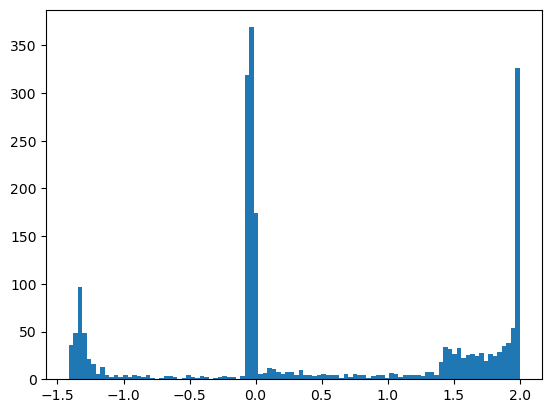

In [320]:
plt.hist(eigenvalues[:, 1], bins=100)
plt.show()